In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import os

In [2]:
if not os.path.exists("data.pkl"):
    from ucimlrepo import fetch_ucirepo

    # fetch dataset
    secondary_mushroom = fetch_ucirepo(id=848)

    df = secondary_mushroom.data.features
    df = df.assign(target=secondary_mushroom.data.targets)
    with open("data.pkl", "wb") as f:
        pickle.dump(df, f)
else:
    with open("data.pkl", "rb") as f:
        df = pickle.load(f)
df["target"] = (df["target"] == "p").astype(int)

# Оценка данных

## Обработка данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          61069 non-null  float64
 1   cap-shape             61069 non-null  object 
 2   cap-surface           46949 non-null  object 
 3   cap-color             61069 non-null  object 
 4   does-bruise-or-bleed  61069 non-null  object 
 5   gill-attachment       51185 non-null  object 
 6   gill-spacing          36006 non-null  object 
 7   gill-color            61069 non-null  object 
 8   stem-height           61069 non-null  float64
 9   stem-width            61069 non-null  float64
 10  stem-root             9531 non-null   object 
 11  stem-surface          22945 non-null  object 
 12  stem-color            61069 non-null  object 
 13  veil-type             3177 non-null   object 
 14  veil-color            7413 non-null   object 
 15  has-ring           

In [4]:
real_features = ["cap-diameter", "stem-height", "stem-width"]
nullable_features = ["stem-root", "veil-type", "veil-color", "spore-print-color"]
cat_features = list(
    set(df.columns) - set(real_features) - set(["target"]) - set(nullable_features)
)


### Label Encoder

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
le = LabelEncoder()

lable_encoded_cat_features = []
for feat in cat_features:
    df[feat + "_LE"] = le.fit_transform(df[feat])
    lable_encoded_cat_features.append(feat + "_LE")

In [7]:
df[lable_encoded_cat_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   cap-surface_LE           61069 non-null  int32
 1   season_LE                61069 non-null  int32
 2   stem-surface_LE          61069 non-null  int32
 3   gill-spacing_LE          61069 non-null  int32
 4   gill-color_LE            61069 non-null  int32
 5   habitat_LE               61069 non-null  int32
 6   gill-attachment_LE       61069 non-null  int32
 7   has-ring_LE              61069 non-null  int32
 8   does-bruise-or-bleed_LE  61069 non-null  int32
 9   ring-type_LE             61069 non-null  int32
 10  cap-shape_LE             61069 non-null  int32
 11  cap-color_LE             61069 non-null  int32
 12  stem-color_LE            61069 non-null  int32
dtypes: int32(13)
memory usage: 3.0 MB


In [8]:
df[lable_encoded_cat_features]

,cap-surface_LE,season_LE,stem-surface_LE,gill-spacing_LE,gill-color_LE,habitat_LE,gill-attachment_LE,has-ring_LE,does-bruise-or-bleed_LE,ring-type_LE,cap-shape_LE,cap-color_LE,stem-color_LE
0,2,3,7,3,10,0,2,1,0,2,6,6,11
1,2,2,7,3,10,0,2,1,0,2,6,6,11
2,2,3,7,3,10,0,2,1,0,2,6,6,11
3,3,3,7,3,10,0,2,1,0,5,2,1,11
4,3,3,7,3,10,0,2,1,0,5,6,6,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61064,7,0,8,2,2,0,3,0,0,1,5,11,12
61065,7,0,8,2,2,0,3,0,0,1,2,11,12
61066,7,2,8,2,2,0,3,0,0,1,5,11,12
61067,7,2,8,2,2,0,3,0,0,1,2,11,12


<Axes: >

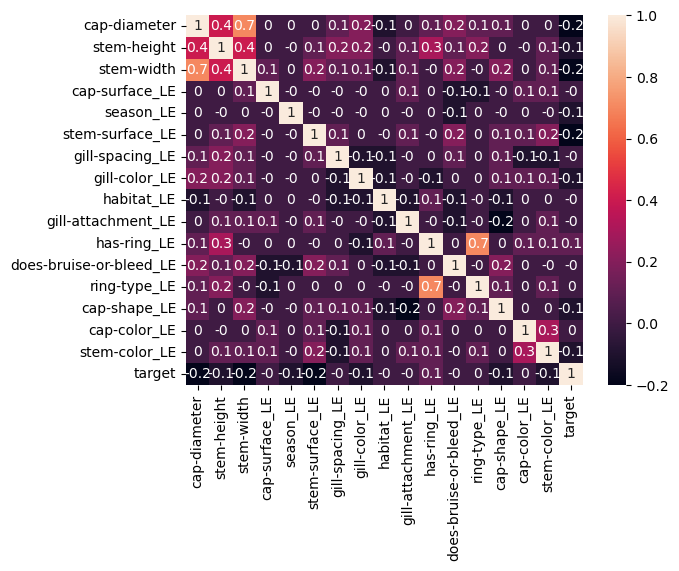

In [9]:
sns.heatmap(
    np.round(df[real_features + lable_encoded_cat_features + ["target"]].corr(), 1), annot=True
)

### One Hot

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
df["gill-spacing"].unique()

array([nan, 'c', 'd', 'f'], dtype=object)

In [12]:
ohe = OneHotEncoder(sparse_output=False, drop="first")
cols = ohe.fit_transform(df[cat_features])
ohe_columns_name = list(ohe.get_feature_names_out(cat_features))

In [13]:
df = pd.concat([df, pd.DataFrame(cols, columns=ohe_columns_name)], axis=1)

<Axes: >

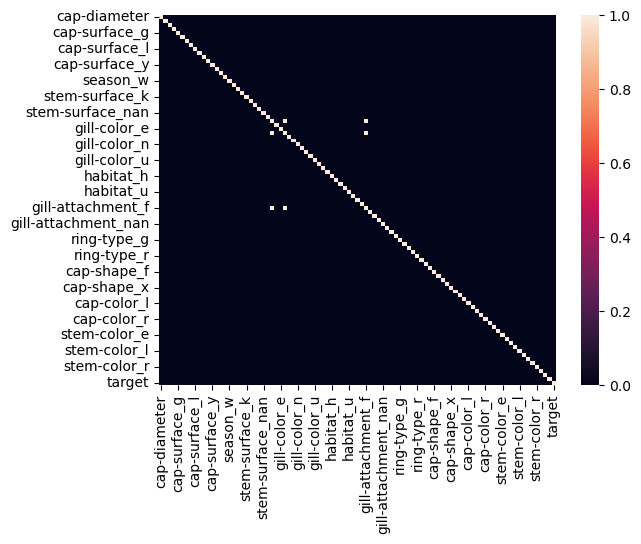

In [14]:
sns.heatmap(
    df[real_features + ohe_columns_name + ["target"]].corr() > 0.75
)


In [15]:
corrs = df[real_features + ohe_columns_name + ["target"]].corr()
corrs_without_diag = (corrs > 0.75) - np.eye(
    df[real_features + ohe_columns_name + ["target"]].shape[1]
)
inds = corrs_without_diag[(corrs_without_diag > 0).any()].index
corrs.loc[inds, inds]

ohe_columns_name.remove(inds[1])
ohe_columns_name.remove(inds[2])

<Axes: >

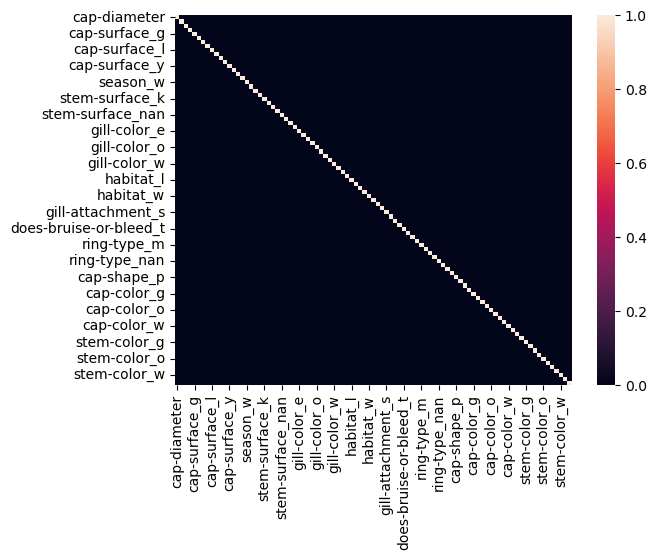

In [16]:
sns.heatmap(df[real_features + ohe_columns_name + ["target"]].corr() > 0.75)

### Feature batched

In [19]:
df[real_features[0]]

0        15.26
1        16.60
2        14.07
3        14.17
4        14.64
         ...  
61064     1.18
61065     1.27
61066     1.27
61067     1.24
61068     1.17
Name: cap-diameter, Length: 61069, dtype: float64

In [42]:
one_rule_features = []
for feat in real_features:
    df[feat + "_mean"] = df[feat] > df[feat].mean()
    one_rule_features.append(feat + "_mean")
    quants = [0.25, 0.5, 0.75]
    _, bins = pd.qcut(df[feat], quants, retbins=True)
    for b, q in zip(bins, quants):
        df[feat + f"q_{q}"] = df[feat] > b
        one_rule_features.append(feat + f"q_{q}")


## Feature selection

In [43]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

In [44]:
default_le_features = real_features + lable_encoded_cat_features
default_ohe_features = real_features + ohe_columns_name

In [45]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=5000).fit(
    df[default_ohe_features], df["target"]
)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.fit_transform(df[default_ohe_features])
linear_svc_based_features = model.get_feature_names_out()
print(linear_svc_based_features)


['cap-diameter' 'stem-height' 'stem-width' 'cap-surface_e' 'cap-surface_h'
 'cap-surface_i' 'cap-surface_k' 'cap-surface_l' 'cap-surface_s'
 'cap-surface_t' 'cap-surface_w' 'cap-surface_y' 'cap-surface_nan'
 'season_s' 'season_u' 'season_w' 'stem-surface_g' 'stem-surface_h'
 'stem-surface_k' 'stem-surface_s' 'stem-surface_t' 'stem-surface_y'
 'stem-surface_nan' 'gill-spacing_d' 'gill-spacing_f' 'gill-spacing_nan'
 'gill-color_e' 'gill-color_k' 'gill-color_n' 'gill-color_o'
 'gill-color_p' 'gill-color_r' 'gill-color_u' 'gill-color_w'
 'gill-color_y' 'habitat_g' 'habitat_h' 'habitat_l' 'habitat_m'
 'habitat_p' 'habitat_w' 'gill-attachment_d' 'gill-attachment_e'
 'gill-attachment_p' 'gill-attachment_s' 'gill-attachment_x'
 'gill-attachment_nan' 'has-ring_t' 'ring-type_f' 'ring-type_g'
 'ring-type_l' 'ring-type_m' 'ring-type_r' 'ring-type_z' 'ring-type_nan'
 'cap-shape_c' 'cap-shape_f' 'cap-shape_o' 'cap-shape_p' 'cap-shape_s'
 'cap-shape_x' 'cap-color_e' 'cap-color_g' 'cap-color_k' 'cap-c

In [46]:
clf = ExtraTreesClassifier(n_estimators=100)
clf = clf.fit(df[default_le_features], df["target"])
print(clf.feature_importances_)
model = SelectFromModel(clf, prefit=True)
X_new = model.fit_transform(df[default_le_features])
tree_based_features = model.get_feature_names_out()
print(tree_based_features)


[0.05398923 0.04421653 0.07795945 0.09793779 0.01409306 0.09583117
 0.08107327 0.07283614 0.03536074 0.11238468 0.03228989 0.04606122
 0.03548445 0.06072281 0.05548008 0.0842795 ]
['stem-width' 'cap-surface_LE' 'stem-surface_LE' 'gill-spacing_LE'
 'gill-color_LE' 'gill-attachment_LE' 'stem-color_LE']


# Построение моделей

## Метрики

In [47]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    auc,
    confusion_matrix,
    RocCurveDisplay,
    roc_curve,
)
from sklearn.model_selection import train_test_split

In [48]:
def metrics(
    X, train_proba, train_pred, train_target, test_proba, test_pred, test_target
):
    print(
        f"{'Accurcy':<20}: Train - {accuracy_score(train_target, train_pred):.3f} Test - {accuracy_score(test_target, test_pred):.3f}"
    )
    print(
        f"{'F1 score':<20}: Train - {f1_score(train_target, train_pred):.3f} Test - {f1_score(test_target, test_pred):.3f}"
    )

    fpr_train, tpr_train, thresholds = roc_curve(train_target, train_proba)
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, thresholds = roc_curve(test_target, test_proba)
    roc_auc_test = auc(fpr_test, tpr_test)

    print(
        f"{'Roc Auc score':<20}: Train - {roc_auc_train:.3f} Test - {roc_auc_test:.3f}"
    )
    fig, ax = plt.subplots(2, 2)

    ax[0, 0].set_title("Train conf")
    confusion_matrix_value = confusion_matrix(train_target, train_pred) / len(
        train_target
    )
    sns.heatmap(confusion_matrix_value, annot=True, fmt="g", vmin=0, ax=ax[0, 0])

    ax[0, 1].set_title("Test conf")
    confusion_matrix_value = confusion_matrix(test_target, test_pred) / len(test_target)
    sns.heatmap(confusion_matrix_value, annot=True, fmt="g", vmin=0, ax=ax[0, 1])

    ax[1, 0].set_title("Train roc curve")
    display = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train)
    display.plot(ax=ax[1, 0])

    ax[1, 1].set_title("Test roc curve")
    display = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, roc_auc=roc_auc_test)
    display.plot(ax=ax[1, 1])
    plt.show()


In [49]:
train, test = train_test_split(df, test_size=0.2)

## OneRule

In [50]:
from mlxtend.classifier import OneRClassifier

Accurcy             : Train - 0.621 Test - 0.626
F1 score            : Train - 0.666 Test - 0.670
Roc Auc score       : Train - 0.614 Test - 0.619


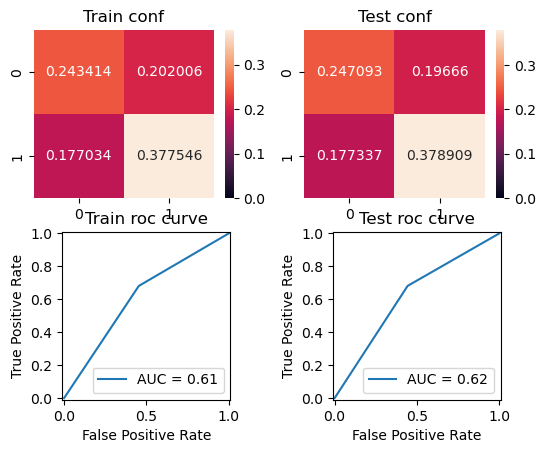

In [55]:
model = OneRClassifier()
feature_list = lable_encoded_cat_features + one_rule_features
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
pred_test = model.predict(test[feature_list].values)

metrics(
    train[feature_list],
    pred_train,
    pred_train,
    train["target"],
    pred_test,
    pred_test,
    test["target"],
)


## Logistic regression

In [27]:
from sklearn.linear_model import LogisticRegression

Accurcy             : Train - 0.824 Test - 0.824
F1 score            : Train - 0.839 Test - 0.839
Roc Auc score       : Train - 0.891 Test - 0.890


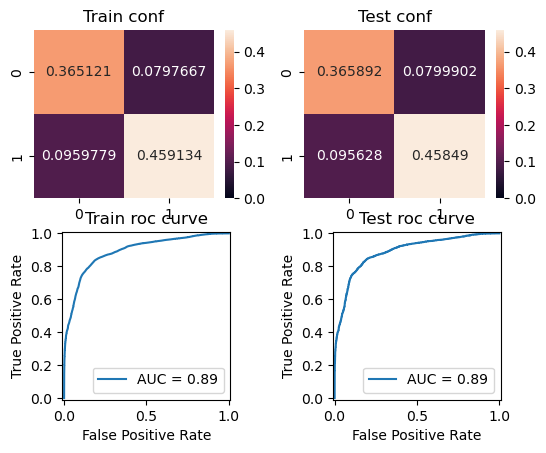

In [28]:
feature_list = default_ohe_features
model = LogisticRegression(max_iter=5000)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 0.825 Test - 0.825
F1 score            : Train - 0.840 Test - 0.840
Roc Auc score       : Train - 0.890 Test - 0.889


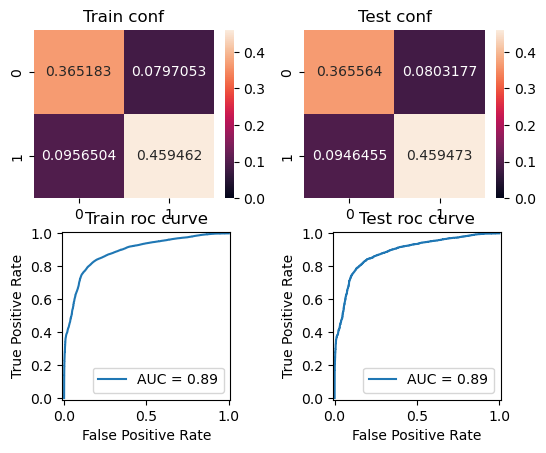

In [29]:
feature_list = linear_svc_based_features
model = LogisticRegression(max_iter=5000)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

## KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier

Accurcy             : Train - 1.000 Test - 0.999
F1 score            : Train - 1.000 Test - 0.999
Roc Auc score       : Train - 1.000 Test - 1.000


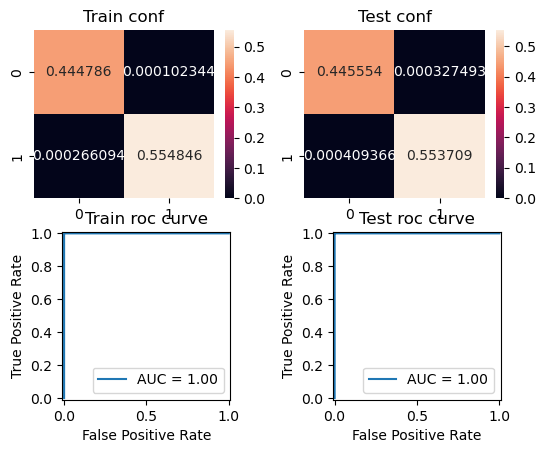

In [31]:
feature_list = default_ohe_features
model = KNeighborsClassifier()
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 1.000 Test - 0.999
F1 score            : Train - 1.000 Test - 0.999
Roc Auc score       : Train - 1.000 Test - 1.000


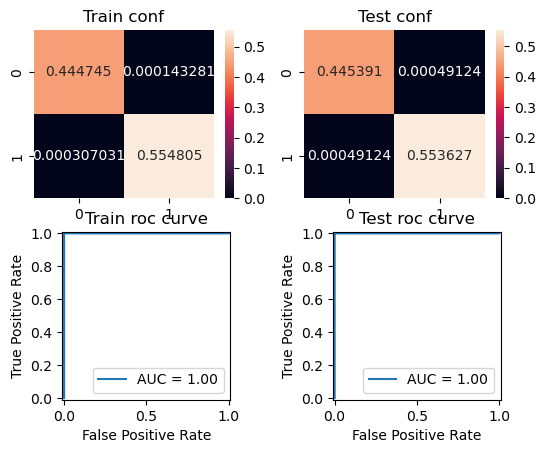

In [32]:
feature_list = linear_svc_based_features
model = KNeighborsClassifier()
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

## Naive baies

In [33]:
from sklearn.naive_bayes import MultinomialNB

Accurcy             : Train - 0.729 Test - 0.732
F1 score            : Train - 0.756 Test - 0.759
Roc Auc score       : Train - 0.812 Test - 0.816


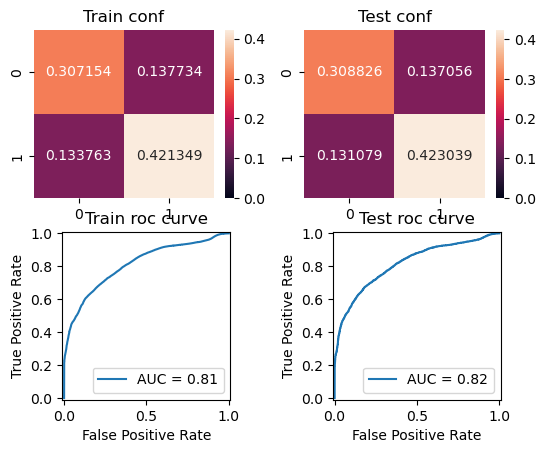

In [34]:
feature_list = default_ohe_features
model = MultinomialNB()
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 0.728 Test - 0.730
F1 score            : Train - 0.756 Test - 0.758
Roc Auc score       : Train - 0.808 Test - 0.812


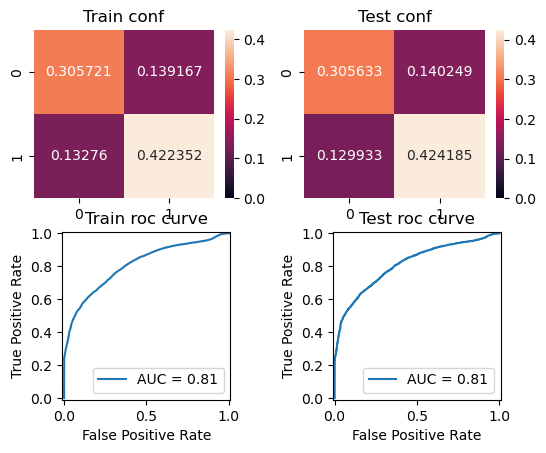

In [35]:
feature_list = linear_svc_based_features
model = MultinomialNB()
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

## Desicion tree

In [36]:
from sklearn.tree import DecisionTreeClassifier

Accurcy             : Train - 0.914 Test - 0.910
F1 score            : Train - 0.922 Test - 0.919
Roc Auc score       : Train - 0.974 Test - 0.971


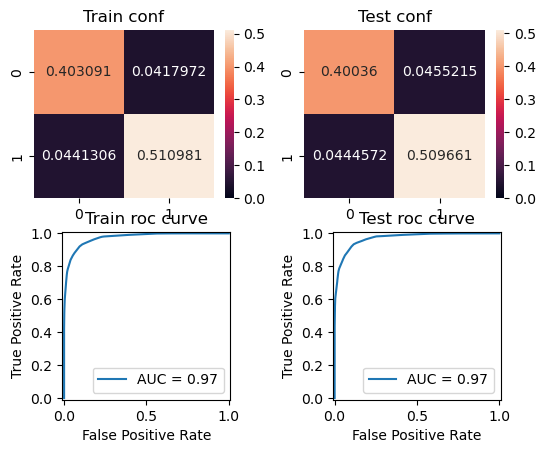

In [37]:
feature_list = default_le_features
model = DecisionTreeClassifier(max_depth=8)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 0.924 Test - 0.921
F1 score            : Train - 0.933 Test - 0.931
Roc Auc score       : Train - 0.983 Test - 0.982


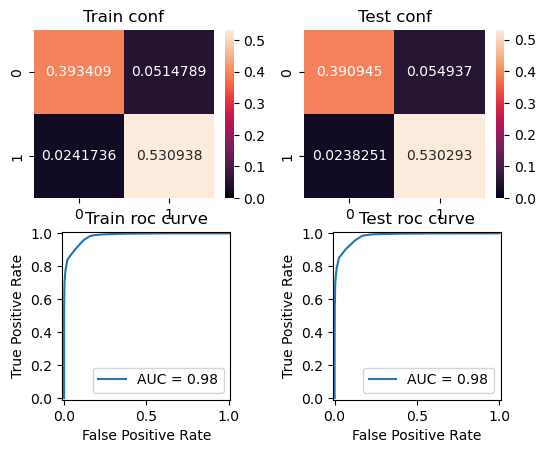

In [38]:
feature_list = tree_based_features
model = DecisionTreeClassifier(max_depth=8)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

## Boosting

In [39]:
from catboost import CatBoostClassifier

Accurcy             : Train - 1.000 Test - 1.000
F1 score            : Train - 1.000 Test - 1.000
Roc Auc score       : Train - 1.000 Test - 1.000


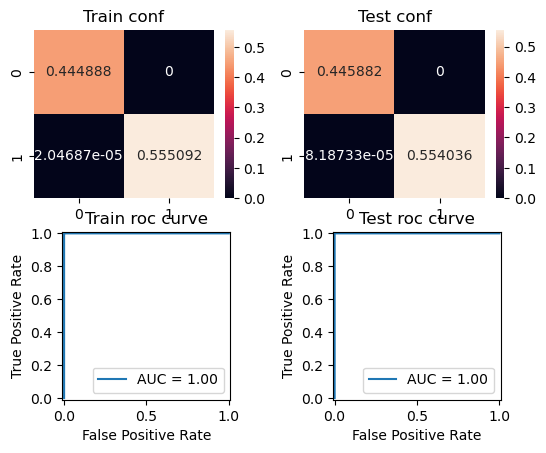

In [40]:
feature_list = real_features + cat_features
catboost_features = list(set(cat_features) & set(feature_list))

t_df = train[feature_list + ["target"]]
test_df = test[feature_list + ["target"]]

t_df.loc[:, catboost_features] = t_df[catboost_features].astype(str)
test_df.loc[:, catboost_features] = test_df[catboost_features].astype(str)

model = CatBoostClassifier(cat_features=catboost_features)
model.fit(t_df[feature_list], t_df["target"].values, silent=True)

pred_train = model.predict(t_df[feature_list])
proba_train = model.predict_proba(t_df[feature_list])[:, 1]
pred_test = model.predict(test_df[feature_list])
proba_test = model.predict_proba(test_df[feature_list])[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 0.998 Test - 0.998
F1 score            : Train - 0.998 Test - 0.998
Roc Auc score       : Train - 1.000 Test - 1.000


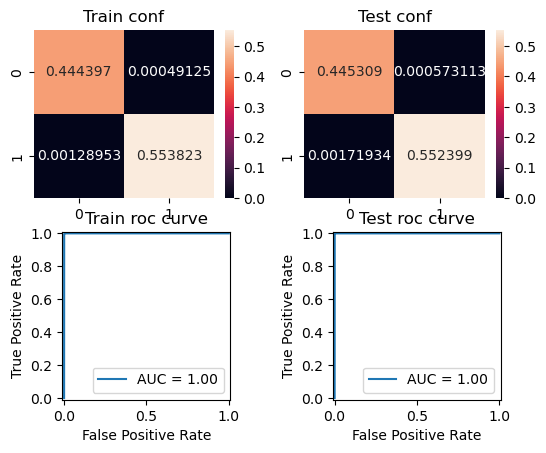

In [41]:
feature_list = list(tree_based_features)
catboost_features = list(set(tree_based_features) & set(lable_encoded_cat_features))
t_df = train[feature_list + ["target"]]
test_df = test[feature_list + ["target"]]
t_df.loc[:, catboost_features] = t_df[catboost_features].astype(int)
test_df.loc[:, catboost_features] = test_df[catboost_features].astype(int)
model = CatBoostClassifier(cat_features=catboost_features)
model.fit(t_df[feature_list], t_df["target"].values, silent=True)
pred_train = model.predict(t_df[feature_list])
proba_train = model.predict_proba(t_df[feature_list])[:, 1]
pred_test = model.predict(test_df[feature_list])
proba_test = model.predict_proba(test_df[feature_list])[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

## SVC

In [42]:
from sklearn.svm import LinearSVC

from sklearn.calibration import CalibratedClassifierCV


Accurcy             : Train - 0.824 Test - 0.826
F1 score            : Train - 0.840 Test - 0.842
Roc Auc score       : Train - 0.890 Test - 0.889


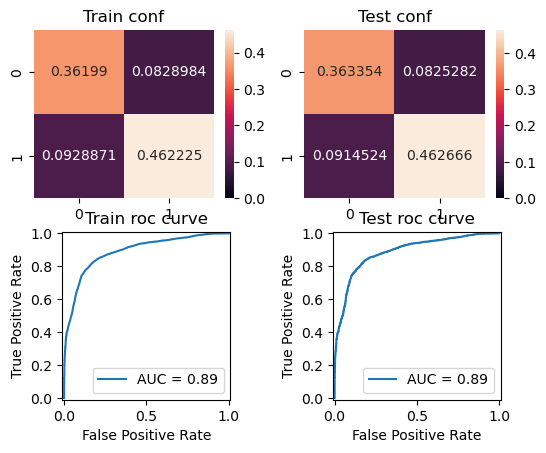

In [43]:
feature_list = default_ohe_features

model = CalibratedClassifierCV(LinearSVC(dual='auto'))
model.fit(train[feature_list], train["target"].values)
pred_train = model.predict(train[feature_list])
proba_train = model.predict_proba(train[feature_list])[:, 1]
pred_test = model.predict(test[feature_list])
proba_test = model.predict_proba(test[feature_list])[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)


Accurcy             : Train - 0.823 Test - 0.824
F1 score            : Train - 0.839 Test - 0.840
Roc Auc score       : Train - 0.889 Test - 0.888


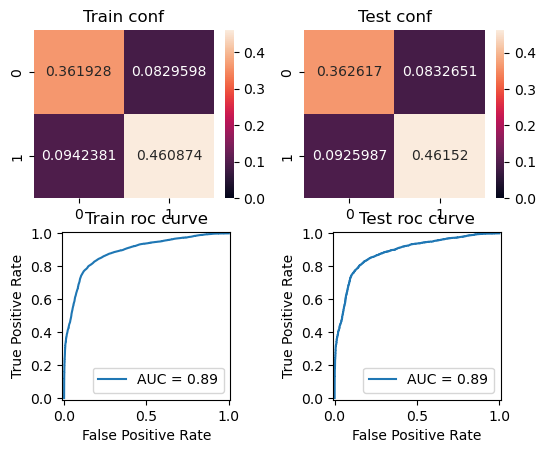

In [44]:
feature_list = linear_svc_based_features

model = CalibratedClassifierCV(LinearSVC(dual="auto"))
model.fit(train[feature_list], train["target"].values)
pred_train = model.predict(train[feature_list])
proba_train = model.predict_proba(train[feature_list])[:, 1]
pred_test = model.predict(test[feature_list])
proba_test = model.predict_proba(test[feature_list])[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)


## MLP

In [45]:
from sklearn.neural_network import MLPClassifier

Accurcy             : Train - 1.000 Test - 1.000
F1 score            : Train - 1.000 Test - 1.000
Roc Auc score       : Train - 1.000 Test - 1.000


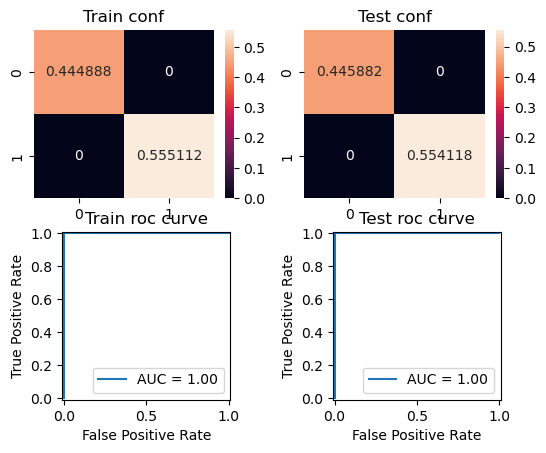

In [46]:
feature_list = default_ohe_features

model = MLPClassifier()
model.fit(train[feature_list], train["target"].values)
pred_train = model.predict(train[feature_list])
proba_train = model.predict_proba(train[feature_list])[:, 1]
pred_test = model.predict(test[feature_list])
proba_test = model.predict_proba(test[feature_list])[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)


Accurcy             : Train - 1.000 Test - 1.000
F1 score            : Train - 1.000 Test - 1.000
Roc Auc score       : Train - 1.000 Test - 1.000


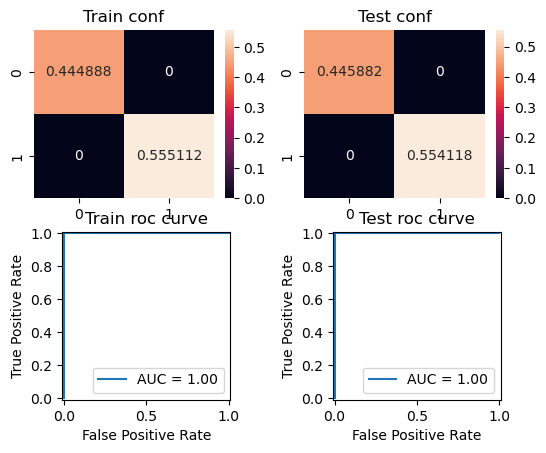

In [47]:
feature_list = linear_svc_based_features

model = MLPClassifier()
model.fit(train[feature_list], train["target"].values)
pred_train = model.predict(train[feature_list])
proba_train = model.predict_proba(train[feature_list])[:, 1]
pred_test = model.predict(test[feature_list])
proba_test = model.predict_proba(test[feature_list])[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)


## Ensamble

In [61]:
from sklearn.ensemble import GradientBoostingClassifier

Accurcy             : Train - 0.925 Test - 0.924
F1 score            : Train - 0.933 Test - 0.933
Roc Auc score       : Train - 0.977 Test - 0.975


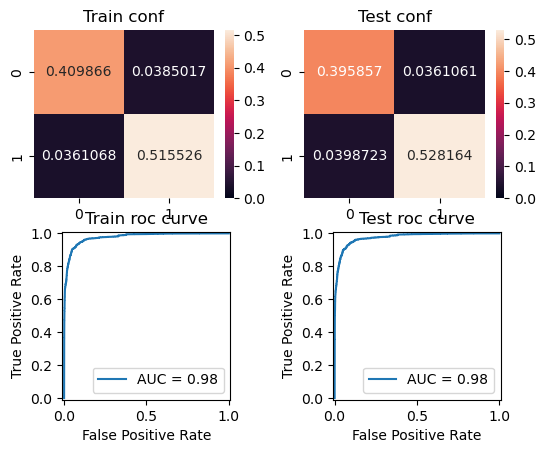

In [63]:
feature_list = default_le_features

model = GradientBoostingClassifier()
model.fit(train[feature_list], train["target"].values)
pred_train = model.predict(train[feature_list])
proba_train = model.predict_proba(train[feature_list])[:, 1]
pred_test = model.predict(test[feature_list])
proba_test = model.predict_proba(test[feature_list])[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)


In [65]:
from sklearn.ensemble import RandomForestClassifier

Accurcy             : Train - 1.000 Test - 1.000
F1 score            : Train - 1.000 Test - 1.000
Roc Auc score       : Train - 1.000 Test - 1.000


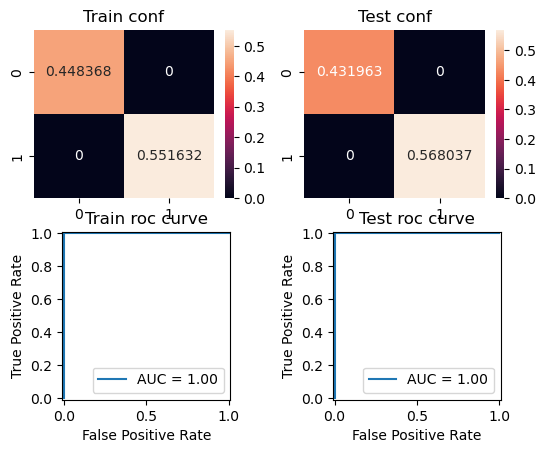

In [66]:
feature_list = default_le_features

model = RandomForestClassifier()
model.fit(train[feature_list], train["target"].values)
pred_train = model.predict(train[feature_list])
proba_train = model.predict_proba(train[feature_list])[:, 1]
pred_test = model.predict(test[feature_list])
proba_test = model.predict_proba(test[feature_list])[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)
